## Risk Classification  - Life Insurance Data

*Risk Classification* is the task of classifies risk of the person
<center> <img src="iStock_insurancehands300.png" title="Life Insurance"></img> </center>
The below are the topics which the notebook covered,<br>

<ul>
    - <a href="#readDataset">Read Dataset</a><br>
    - <a href="#labelCount">Response Vs No of records</a><br>
    - <a href="#preprocess">Preprocessing</a><br>
    - <a href="#featureSelection">Feature Selection</a><br>
    - <a href="#buildModel">Build Model</a><br>
    - <a href="#lime">Understanding Model Predictions with LIME</a></ul>

In [106]:
#Necessary packages
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

<a id="readDataset"></a>
### Read Dataset

In [2]:
# construct dataframe using pandas
df = pd.read_csv("data/Training.csv")

In [3]:
print ("Dimension of the dataset",df.shape)
df.head()

Dimension of the dataset (59381, 128)


,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


<a id="labelCount"></a>
## Response Vs No of records

No of classes available 8
target variables [8 4 1 6 2 7 3 5] 


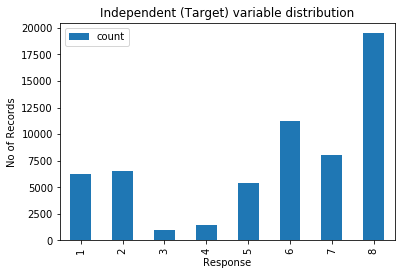

In [4]:
# Get the unique target variable
target_variable = df.Response.unique()
print ("No of classes available %s\ntarget variables %s " % (len(target_variable),target_variable ))
# Identify the no of records available for each target variable
class_distribution = df[["Id","Response"]].groupby("Response").agg("count").rename(index=str,columns={"Id":"count"})
class_distribution.plot(kind='bar')
plt.xlabel("Response")
plt.ylabel("No of Records")
plt.title("Independent (Target) variable distribution")
plt.show()

The above diagram shows the distribution of independent variable
    - Response 8 has high frequency compared to other responses
    - Response 3 and 4 has very low frequency
    - These both responses makes problem while building model due to imbalance in the class variables
    - Need to be careful while splitting data for training and testing because the way we split should be cater for each class with minimum no of records. Randomly split data is not a best option for this

<a id="preprocess"></a>
## Preprocessing

In [5]:
# Check any missing values available in the data
df.isnull().sum()[df.isnull().sum() > 0]

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

Oh! There are huge values are missing in the data.

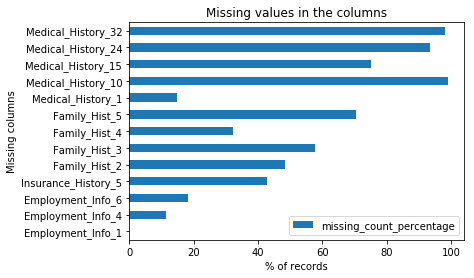

In terms of percentage in the overall dataset, There are many columns have more than 50% records are missing
Let's see how we can impute those values


In [6]:
# Check how much percentage of data has been missing in the data
missing_df= df.isnull().sum()[df.isnull().sum() !=0]
missing_df=pd.DataFrame(missing_df.reset_index())
missing_df.rename(columns={'index':'features',0:'missing_count'},inplace=True)
missing_df['missing_count_percentage']=((missing_df['missing_count'])/len(df))*100
missing_df.index = missing_df['features']
missing_df[['missing_count_percentage','features']].plot(kind='barh')
plt.ylabel("Missing columns")
plt.xlabel("% of records")
plt.title("Missing values in the columns")
plt.show()

############
print("In terms of percentage in the overall dataset, There are many columns have more than 50% records are missing")
print("Let's see how we can impute those values")

The below are data type of missing values columns
    - Employment_Info_1, Employment_Info_4, Employment_Info_6,Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5 are continous 
    - Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32 are discrete
    
Let's start with continous variable first

In [7]:
len(df[df['Medical_History_1'].isnull()])

8889

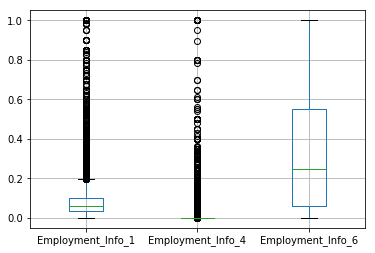

In [8]:
# Let's draw box plot for Employment Info columns
boxplot = df.boxplot(column=['Employment_Info_1','Employment_Info_4','Employment_Info_6'])

The above box-plot drawn for Employment info because it has very less missing values.
The following are key points,

Employment_Info_1:
    - It has lot of outlier. So if we take mean value to fill the missing values, It won't makes sense. Should prefer the Median value 

Employment_Info_4:
    - lot of outlier. So we should prefer median value to fill missing values
    
Employment_Info_6:
    - No outliers. Looks good with mean, 25% value and 75% value. There is not much variance in the data.So we should go with mean value to fill missing values

In [9]:
df['Employment_Info_1'].fillna(df['Employment_Info_1'].median(),inplace=True)
df['Employment_Info_4'].fillna(df['Employment_Info_4'].median(),inplace=True)
df['Employment_Info_6'].fillna(df['Employment_Info_6'].mean(),inplace=True)

In [10]:
print ("Check whether null values are present in the columns")
df['Employment_Info_1'].isnull().sum(),df['Employment_Info_4'].isnull().sum(),df['Employment_Info_6'].isnull().sum()

Check whether null values are present in the columns


(0, 0, 0)

In [11]:
# Medical History 1 has less missing values. So trying to replace with maximum no of frequency data
print("No of unique values ",len(df.Medical_History_1.unique()),"\n",df.Medical_History_1.unique())

No of unique values  172 
 [  4.   5.  10.   0.  nan   6.   1.  39.  61.   8.   2.   3.  22.  11.
  19.   7.  16.  12.  49.   9.  13.  15.  47.  57.  24.  23.  62.  28.
  44.  32.  17.  18.  34.  30. 153.  21.  86.  14.  25.  36.  42.  26.
  20.  64.  29.  55. 124.  27. 114.  40.  31.  41.  46.  76.  51.  65.
  66.  78. 154. 147.  37.  80.  71.  85. 105.  53.  56.  68.  52.  77.
  33.  50.  73.  35.  70. 182.  95.  43.  72.  84.  54.  48.  38.  45.
 112. 134.  88.  63.  69. 158. 120.  59. 100. 119.  74.  82.  58.  97.
  90.  96. 123.  94. 160. 156. 113. 176.  60.  75.  91.  79.  81. 121.
 103.  83. 240. 128.  93. 136. 122.  87.  92. 110. 178. 175. 171.  89.
  67. 169.  99. 229. 223. 109. 146. 118. 141. 107. 104. 117. 130. 159.
 172. 108. 191. 201.  98. 161. 115. 173. 102. 106. 162. 150. 125. 179.
 148. 132. 116. 138. 126. 193. 101. 239. 185. 145. 143. 111. 155. 131.
 180. 127. 228. 187.]


In [12]:
# Fill medical history with most frequent used in the data
most_frequent_medicalHistory = int(df[["Medical_History_1","Medical_History_2"]].groupby("Medical_History_1").agg("count").sort_values(['Medical_History_2'], ascending=False).reset_index()[0:1]["Medical_History_1"])
df["Medical_History_1"].fillna(most_frequent_medicalHistory,inplace=True)

In [13]:
print("No of unique values ",len(df.Medical_History_1.unique()),"\n",df.Medical_History_1.unique())

No of unique values  171 
 [  4.   5.  10.   0.   1.   6.  39.  61.   8.   2.   3.  22.  11.  19.
   7.  16.  12.  49.   9.  13.  15.  47.  57.  24.  23.  62.  28.  44.
  32.  17.  18.  34.  30. 153.  21.  86.  14.  25.  36.  42.  26.  20.
  64.  29.  55. 124.  27. 114.  40.  31.  41.  46.  76.  51.  65.  66.
  78. 154. 147.  37.  80.  71.  85. 105.  53.  56.  68.  52.  77.  33.
  50.  73.  35.  70. 182.  95.  43.  72.  84.  54.  48.  38.  45. 112.
 134.  88.  63.  69. 158. 120.  59. 100. 119.  74.  82.  58.  97.  90.
  96. 123.  94. 160. 156. 113. 176.  60.  75.  91.  79.  81. 121. 103.
  83. 240. 128.  93. 136. 122.  87.  92. 110. 178. 175. 171.  89.  67.
 169.  99. 229. 223. 109. 146. 118. 141. 107. 104. 117. 130. 159. 172.
 108. 191. 201.  98. 161. 115. 173. 102. 106. 162. 150. 125. 179. 148.
 132. 116. 138. 126. 193. 101. 239. 185. 145. 143. 111. 155. 131. 180.
 127. 228. 187.]


count    33985.000000
mean         0.001733
std          0.007338
min          0.000000
25%          0.000400
50%          0.000973
75%          0.002000
max          1.000000
Name: Insurance_History_5, dtype: float64


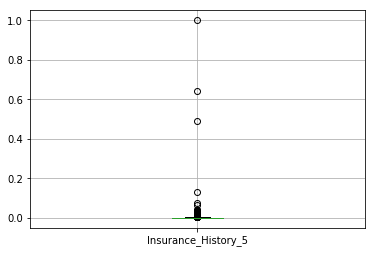

In [14]:
#lets see Insurance_History_5
print(df.Insurance_History_5.describe())
boxplot = df.boxplot(column=['Insurance_History_5'])

Even Insurance_History_5 has lot of outlier in the data. It has 40% more missing values. So Will remove this feature

In [15]:
#lets drop features with high number of missing values 
df.drop(['Medical_History_10','Medical_History_15','Medical_History_24','Medical_History_32','Insurance_History_5',
                 'Family_Hist_2','Family_Hist_3','Family_Hist_4','Family_Hist_5'],
                axis=1,inplace=True)

In [16]:
# convert string into numerical value for product info
le=LabelEncoder()
df['Product_Info_2']=le.fit_transform(df['Product_Info_2'])

In [17]:
print("Final dataframe feature columns ",df.shape)

Final dataframe feature columns  (59381, 119)


<a id="#featureSelection"></a>
## Feature Selection

In [18]:
X = df.iloc[:,1:-1]  # features without ID
y = df.iloc[:,-1]    #target column i.e price range

#apply SelectKBest class to extract top 80 best features
bestfeatures = SelectKBest(score_func=chi2, k=80)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  

print("##### Important features based on SelectKBest using chi-square value")
print(featureScores.nlargest(80,'Score'))  

##### Important features based on SelectKBest using chi-square value
                Features        Score
32     Medical_History_1  9949.778760
83    Medical_Keyword_15  5639.405401
71     Medical_Keyword_3  4339.025870
33     Medical_History_2  2749.627783
52    Medical_History_23  2186.232874
116   Medical_Keyword_48  1650.551405
12     Employment_Info_2  1462.347229
35     Medical_History_4  1181.399564
91    Medical_Keyword_23  1123.683820
93    Medical_Keyword_25   987.312671
1         Product_Info_2   826.736193
3         Product_Info_4   716.825284
106   Medical_Keyword_38   714.827753
2         Product_Info_3   614.718816
45    Medical_History_16   543.331296
110   Medical_Keyword_42   534.524096
69     Medical_Keyword_1   524.587484
10                   BMI   485.966874
13     Employment_Info_3   465.641372
22         InsuredInfo_6   450.313429
105   Medical_Keyword_37   420.561268
92    Medical_Keyword_24   410.946069
7                Ins_Age   404.887633
66    Medical_Histo

The above features are more important than other features based on selection.

Let's filter these column in main dataframe

In [19]:
## Filter important features from the dataframe
feature_names_list = featureScores.nlargest(80,'Score')["Features"].tolist()
feature_names_list.append("Response")
df_important_features = df[feature_names_list]
print (df_important_features.shape)
print(df_important_features.columns)

(59381, 81)
Index(['Medical_History_1', 'Medical_Keyword_15', 'Medical_Keyword_3',
       'Medical_History_2', 'Medical_History_23', 'Medical_Keyword_48',
       'Employment_Info_2', 'Medical_History_4', 'Medical_Keyword_23',
       'Medical_Keyword_25', 'Product_Info_2', 'Product_Info_4',
       'Medical_Keyword_38', 'Product_Info_3', 'Medical_History_16',
       'Medical_Keyword_42', 'Medical_Keyword_1', 'BMI', 'Employment_Info_3',
       'InsuredInfo_6', 'Medical_Keyword_37', 'Medical_Keyword_24', 'Ins_Age',
       'Medical_History_39', 'Wt', 'Medical_Keyword_40', 'Medical_Keyword_22',
       'Medical_Keyword_47', 'Medical_Keyword_10', 'Medical_Keyword_43',
       'Medical_Keyword_46', 'Medical_Keyword_33', 'Insurance_History_4',
       'Insurance_History_7', 'Medical_Keyword_35', 'Insurance_History_3',
       'Medical_Keyword_16', 'Medical_History_13', 'Medical_Keyword_27',
       'Medical_Keyword_31', 'Medical_History_33', 'Medical_History_29',
       'Employment_Info_6', 'Medical

<a id="buildModel"></a>
## Build Model

Spliting data:
    - We are not using randomized split since class variables are imbalanced
    - Trying to use Stratify split data, to make sure each class has same % of split

In [20]:
X_features = df_important_features.iloc[:,:-1]
y_lables = df_important_features["Response"]

# split train and test data using Stratifed Fashion 80-20 split
X_train,X_test,y_train,y_test=train_test_split(X_features,y_lables,stratify=y_lables,test_size=0.20)
print ("Train and test data split")
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

Train and test data split
(47504, 80) (11877, 80) (47504,) (11877,)


In [21]:
parameters = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0]
}

In [22]:
# use random forest classifier
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [320, 330, 340], 'max_depth': [8, 9, 10, 11, 12], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
predictions = clf.predict(X_test)
print("Overall accurracy ",accuracy_score(y_test,predictions))

Overall accurracy  0.5221015407931295


Let define function to plot confusion matrix

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = [1,2,3,4,5,6,7,8]#classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 197  155    0    0   88  332  100  369]
 [  84  319    0    0  142  334  110  321]
 [   3   11    0    0   57   94    4   34]
 [   4    0    0    0    0   91   11  180]
 [  24   90    2    0  544  252   37  137]
 [  67   65    0    0   96 1077  198  744]
 [  14    2    0    0    8  432  465  685]
 [   3    0    0    0    3  225   68 3599]]


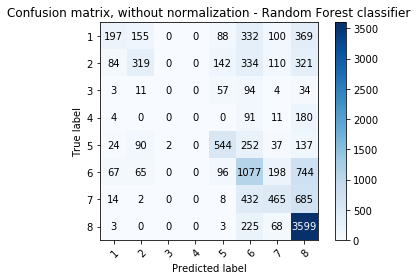

In [69]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=np.sort(y_train.unique()),
                      title='Confusion matrix, without normalization - Random Forest classifier')

In [61]:
print(classification_report(y_test, predictions, target_names=["1","2","3","4","5","6","7","8"]))

             precision    recall  f1-score   support

          1       0.50      0.16      0.24      1241
          2       0.50      0.24      0.33      1310
          3       0.00      0.00      0.00       203
          4       0.00      0.00      0.00       286
          5       0.58      0.50      0.54      1086
          6       0.38      0.48      0.42      2247
          7       0.47      0.29      0.36      1606
          8       0.59      0.92      0.72      3898

avg / total       0.49      0.52      0.48     11877



/home/narendra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The above statistics value not much impressive though.

    - If you look at class 3 and 4 has 0 precision 
    - Model is not able to classify those classes.

In [24]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

In [25]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [37]:
y_pred = xgb_model.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred, y_train.unique()))

0.5276584996211164
[[3465  114  304    5    5    3    2    0]
 [ 610  554  407    1    8   25    1    0]
 [ 613  254 1123   71  117   67    2    0]
 [ 265  124  334  300  172  113    2    0]
 [ 124   49  206   94  582   28    0    3]
 [ 330  111  309  144  111  234    0    2]
 [ 155    9  112    0    0    5    5    0]
 [  25    3   95    9   62    5    0    4]]


/home/narendra/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[ 234  144    2    0  111  309  111  330]
 [ 113  300    0    2  172  334  124  265]
 [   5    9    4    0   62   95    3   25]
 [   5    0    0    5    0  112    9  155]
 [  28   94    3    0  582  206   49  124]
 [  67   71    0    2  117 1123  254  613]
 [  25    1    0    1    8  407  554  610]
 [   3    5    0    2    5  304  114 3465]]


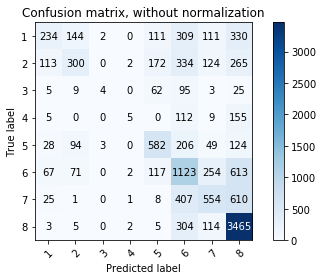

In [47]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=y_train.unique(),
                      title='Confusion matrix, without normalization')

In [63]:
print(classification_report(y_test, y_pred, target_names=["1","2","3","4","5","6","7","8"]))

             precision    recall  f1-score   support

          1       0.49      0.19      0.27      1241
          2       0.48      0.23      0.31      1310
          3       0.44      0.02      0.04       203
          4       0.42      0.02      0.03       286
          5       0.55      0.54      0.54      1086
          6       0.39      0.50      0.44      2247
          7       0.45      0.34      0.39      1606
          8       0.62      0.89      0.73      3898

avg / total       0.51      0.53      0.49     11877



Even though this model accurracy is close to same as previous. But, statistics value tells us compartively good as previous model.

    - Class 3 and 4 has been able to identify from the model
    - Overall precision and recall just increased
    
So, We can deploy this model as Rest API to test 



In [107]:
# Save model to pkl file 

import pickle
# Dump the trained decision tree classifier with Pickle
random_forest_pkl_filename = 'model/random_forest_classifier_gridcv.pkl'
# Open the file to save as pkl file
random_forest_pkl = open(random_forest_pkl_filename, 'wb')
pickle.dump(clf, random_forest_pkl)
# Close the pickle instances
random_forest_pkl.close()

In [108]:
# Dump the trained decision tree classifier with Pickle
xgboost_classifier_pkl_filename = 'model/xgboost_classifier.pkl'
# Open the file to save as pkl file
xgboost_classifier_model_pkl = open(xgboost_classifier_pkl_filename, 'wb')
pickle.dump(xgb_model, xgboost_classifier_model_pkl)
# Close the pickle instances
xgboost_classifier_model_pkl.close()

<a id="lime"></a>
## Understanding Model with LIME Explainer
<br>
<center> <img src="black_box.png" title="ML"></img> </center>

Once we build the machine learning model is not our job done.

Machine learning models are black box models. How do we trust our model? 

Oh yes. There is Local Interpretable Model-agnostic Explanations (LIME) technique

The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.